# Secure transmission of information using GHZ states
### *Authors: Tanay Roy, Ankur Agrawal, Ziqian Li*
Here we demonstrate how to send classical information securely by using superdense coding with three-qubit GHZ states. In this scheme, Alice and Bob share a GHZ state where Alice keeps 2 qubits. She performs local operations on her qubits to encode 3 bits of information and sends the qubits to Bob. Bob performs measurement in the GHZ basis to extract the information deterministically. This transmission is secure since no information can be obtained by stealing the two qubits to be transmitted. Apart from being secure, this method also enhances the channel capacity by a factor of 3/2=1.5.

We transmit two different kinds of messages - a grayscale picture and an alphanumeric text.

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import pi
from random import randint
from collections import Counter
from PIL import Image as img

%matplotlib inline

from qiskit import QuantumCircuit, BasicAer, Aer, execute, IBMQ
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import partial_trace
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.tools.monitor import job_monitor

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
simulator = Aer.get_backend('qasm_simulator')
sv_simulator = BasicAer.get_backend('statevector_simulator')
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_ourense')

## Functions related to secure transmission using two Bell pairs

In [3]:
def GHZ_state(qc, qubits=[0,1,2]):
    qc.h(qubits[0])
    qc.cx(qubits[0],qubits[1])
    qc.cx(qubits[1],qubits[2])

def GHZ_basis_transform(qc, qubits=[0,1,2]):
    qc.cx(qubits[1],qubits[2])
    qc.cx(qubits[0],qubits[1])
    qc.h(qubits[0])
    
def encode_info_in_GHZ(qc, data=0, qubits=[0,1]):
    if data == 1:
        qc.z(qubits[0])
    if data == 2:
        qc.x(qubits[0])
    if data == 3:
        qc.z(qubits[0])
        qc.x(qubits[0])
    if data == 4:
        qc.x(qubits[0])
        qc.x(qubits[1])
    if data == 5:
        qc.z(qubits[0])
        qc.x(qubits[0])
        qc.x(qubits[1])
    if data == 6:
        qc.x(qubits[1])
    if data == 7:
        qc.z(qubits[0])
        qc.x(qubits[1])

        
def transmit_GHZ_data_arr_old(data_arr=[0,1], backend=simulator, shots=1, monitor=True):
    
    circuit_list = []
    for data in data_arr:
        
        qc = QuantumCircuit(3)
        GHZ_state(qc)
        encode_info_in_GHZ(qc, data=data)
        GHZ_basis_transform(qc)
        qc.measure_all()

        circuit_list.extend([qc])
        
    # Execute on quantum hardware
    job_GHZ = execute(circuit_list, backend=backend, shots=shots)
    if monitor: job_monitor(job_GHZ)
    
    return job_GHZ.result()


def transmit_GHZ_data_arr(data_arr=[0,1], qubits=[0,1,2], backend=simulator, shots=1, monitor=True):
    
    circuit_list = []
    for data in data_arr:
        
        qc = QuantumCircuit(max(qubits)+1,3)
        GHZ_state(qc, qubits=qubits)
        encode_info_in_GHZ(qc, data=data, qubits=[qubits[0],qubits[1]])
        GHZ_basis_transform(qc, qubits=qubits)
        qc.barrier(qubits)
        qc.measure(qubits,[0,1,2])

        circuit_list.extend([qc])
        
    # Execute on quantum hardware
    job_GHZ = execute(circuit_list, backend=backend, shots=shots)
    if monitor: job_monitor(job_GHZ)
    
    return job_GHZ.result()


def analyze_GHZ_result(results):
    # Assumes single output: shots = 1
    data_out = []
    for result in results.get_counts():
        for state,count in result.items():
            data_out.append(int(state, 2)) # Binary string to integer
                
    return data_out


def transmit_GHZ_long_data(data_1d_2d, qubits=[0,1,2], backend=simulator, shots=1, monitor=True, max_data_per_run=75):
    
    data_1d_2d = np.array(data_1d_2d)
    is2d = False
    if len(data_1d_2d.shape) == 2:
        is2d = True
        rows, cols = data_1d_2d.shape
    data_1d_2d = data_1d_2d.flatten()
    
    data_len = len(data_1d_2d)
    runs = data_len//max_data_per_run
    remainder = data_len%max_data_per_run
    
    data_out = []
    for ii in range(runs):
        data_arr = data_1d_2d[ii*max_data_per_run:(ii+1)*max_data_per_run]
        results = transmit_GHZ_data_arr(data_arr, qubits=qubits, backend=backend, shots=shots, monitor=monitor)
        data_out.extend(analyze_GHZ_result(results))
        
    if remainder > 0:
        data_arr = data_1d_2d[-remainder:]
        results = transmit_GHZ_data_arr(data_arr, qubits=qubits, backend=backend, shots=shots, monitor=monitor)
        data_out.extend(analyze_GHZ_result(results))
        
    data_out = np.array(data_out)
    if is2d: data_out = data_out.reshape(rows,cols)
    return data_out


def find_majority(votes):
    vote_count = Counter(votes)
    top_two = vote_count.most_common(2)
    if len(top_two)>1 and top_two[0][1] == top_two[1][1]:
        # It is a tie
        return -1
    return top_two[0][0]


def find_majority_arr(int_1d_arr_arr, bits=4):
    int_1d_arr_arr = np.transpose(int_1d_arr_arr)
    maj_int_1d_arr = []
    for int_1d_arr in int_1d_arr_arr:
        # First convert integer 1d array to binary 2d array and tranpose
        bin_2d_arr = np.transpose([list(format(ii,'b').zfill(bits)) for ii in int_1d_arr])
        maj_bin_arr = []
        for bin_arr in bin_2d_arr:
            maj_bin_arr.extend(find_majority(bin_arr))
            
        maj = int("".join(maj_bin_arr),2) # Binary string to integer
        maj_int_1d_arr.append(maj)        
        
    return maj_int_1d_arr


def check_success_rate(data_in, data_out):
    correct_count = np.sum(np.multiply(np.array(data_in)==np.array(data_out),1))
    print("Success = %s/%s = %s %%" %(correct_count,data_in.size,correct_count/data_in.size*100))

## Explicit quantum circuit for transmission using a GHZ state

Output bitstring: {'110': 1}


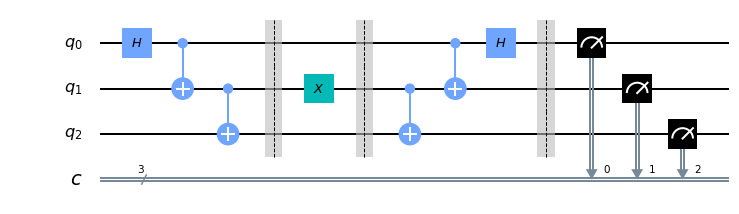

In [4]:
val = 6 # data to be transmitted. Binary(6): '110'

qubits= [0,1,2]
qc = QuantumCircuit(max(qubits)+1,3)
# === Prepare a GHZ state === #
GHZ_state(qc, qubits=qubits)
# === Alice keeps q0,q1 and Bob keeps q2 === #
qc.barrier(qubits)

# === Alice encodes information by applying local operations on q0 and q1 === #
encode_info_in_GHZ(qc, data=val, qubits=[qubits[0],qubits[1]])
# === Alice send q0 and q1 to Bob === #
qc.barrier(qubits)

# === Bob applies gates to perform measurement on Bell basis === #
GHZ_basis_transform(qc, qubits=qubits)
qc.barrier(qubits)
# === Bob performs measurement to recover information (in binary) === #
qc.measure(qubits,[0,1,2])
job_2Bell = execute(qc, backend = simulator, shots=1)

print("Output bitstring:", job_2Bell.result().get_counts())
qc.draw('mpl') # Draw the quantum circuit

The above circuit shows that Alice can transmit 3 bits of classical information by performing local operations (X and Z gates) on her two qubits (q0 and q1) and sending those to Bob. Thus the channel capacity enhancement is 3/2 = 1.5. This transmission is secure since all the information is encoded in the correlation and no information can be obtained by measuring the qubits transmitted by Alice alone.

# Part 1: Image transmission

## Functions related to image processing

In [68]:
# Import functions related to conversion of text to binary message
try:
    import RS 
except:
    !jupyter nbconvert --to python RS.ipynb
    import RS
    
    
def resize_image(file_in, x_pixels=20, y_pixels=20, file_out=None):
    image = img.open(file_in)
    new_image = image.resize((x_pixels, y_pixels))
    if file_out is not None:
        new_image.save(file_out)
    print("Input size: %s, Output size: %s" %(image.size, new_image.size))

    
def convert_to_gray(file_in, file_out=None):
    
    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

    image = mpimg.imread(file_in) 
    gray = rgb2gray(image)
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=max(gray.flatten()))
    if file_out is not None: plt.savefig(file_out)
    return gray


def change_resolution_grayscale_arr(gray_arr, bit_res=4):
    # Use max and min of data to set the full scale
    gray_arr = gray_arr - min(gray_arr.flatten())
    gray_arr = gray_arr/max(gray_arr.flatten())
    res = 2**bit_res - 1
    gray_new = np.round(gray_arr * res)
    return gray_new.astype(int)


def plot_gray_2d_arr(gray_2d_arr):
    plt.imshow(gray_2d_arr, cmap=plt.get_cmap('gray'), vmin=0, vmax=max(gray_2d_arr.flatten()))

    
def check_success_rate(data_in, data_out):
    correct_count = np.sum(np.multiply(np.array(data_in)==np.array(data_out),1))
    print("Success = %s/%s = %s %%" %(correct_count,data_in.size,correct_count/data_in.size*100))

    
def prepare_2darr_GHZ(arr_2d_4bit):
    arr_out = []
    for arr in arr_2d_4bit:
        # Encoding the text message into arrays of 3 bits
        arr_out.append(RS.transmitting(arr, transmission_type, is_picture)[0])
    parity = RS.transmitting(arr, transmission_type, is_picture)[1]
    return np.array(arr_out), parity


def decode_2darr_GHZ(arr_2d_3bit, parity):
    arr_out = []
    for arr in arr_2d_3bit:
        # Decoding the text message into arrays of 4 bits
        arr_out.append(RS.receiving(arr, transmission_type, is_picture, parity))
    return np.array(arr_out)

transmission_type = 1 # 0 for Bell state, 1 for GHZ state
is_picture = 1 # 0 is no, 1 is yes

### Step 1: Choose a color image (40 X 40 pixels)

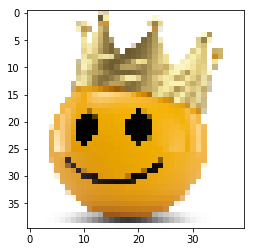

In [10]:
plt.imshow(img.open('happy_small.png'))
plt.show()

### Step 2: Convert the image into grayscale with 4 bit resolution

This is the image to be transmitted securely


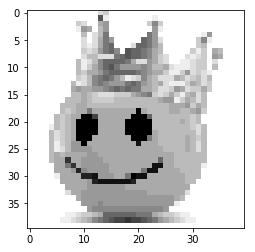

In [5]:
gray_2d_arr = convert_to_gray('happy_small.png')
pic_40_40 = change_resolution_grayscale_arr(gray_2d_arr, bit_res=4)
plot_gray_2d_arr(pic_40_40)
print("This is the image to be transmitted securely")

In [6]:
# Check that all elements are within 0--15
print("20th row:", pic_40_40[20])
print("Max=%s, min=%s" %(max(pic_40_40.flatten()), min(pic_40_40.flatten())))

20th row: [15 15 15 15 15 11 12 11 10  0  0  0  0 10 10 10 10 10  0  0  0  0  0 11
 11 11 11 11 10 11 12 11 15 15 15 15 15 15 15 15]
Max=15, min=0


But this array cannot be sent directly as with a GHZ state one can transmit 3 bits at a time. Thus, we need to convert this array into another array containing a maximum value of 7. This is done by slicing the bitstring appropriately and padding zeros in the end if needed. Another variable parity is used to keep track whether the array is even or odd.

In [75]:
pic_40_40_GHZ, parity = prepare_2darr_GHZ(pic_40_40)

print("20th row:", pic_40_40_GHZ[20])
print("Elements in each row:", len(pic_40_40_GHZ[20]))

20th row: [7 7 7 7 7 7 7 3 6 2 7 2 0 0 0 0 0 2 5 2 5 2 5 2 0 0 0 0 0 0 1 3 5 6 7 3 5
 6 5 3 6 2 7 7 7 7 7 7 7 7 7 7 7 4]
Elements in each row: 54


Essentially, Alice is going to transmit 40\*54=2160 3-bit numbers = 6480 bits of classical information using 4320 qubits. Since, there are some (53 in this case) extra qubits needed for transmission protocol, effective channel capacity enhancement = 6400/4320 = 1.48 (instead of 1.5)

### Step 3: Check the performance using the simulator first

Success = 1600/1600 = 100.0 %


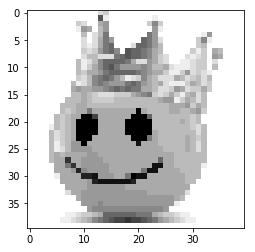

In [18]:
data_in = pic_40_40_GHZ

data_out = transmit_GHZ_long_data(pic_40_40_GHZ, qubits=[0,1,2], backend = simulator, monitor=False)
pic_received = decode_2darr_GHZ(data_out, parity)

check_success_rate(pic_40_40, pic_received)
plot_gray_2d_arr(pic_received)

Of course, an ideal simulator works 100% of the times

### Step 4: Perform the experiment on a real quantum hardware
We have selected the "ibmq_ourense" processor, which seem to have the best performace. It is a 5-qubit processor as shown below.
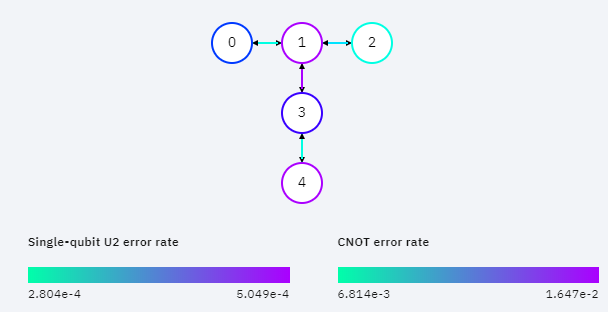

#### Run 1

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

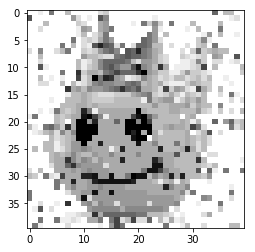

In [19]:
data_out1 = transmit_GHZ_long_data(pic_40_40_GHZ, qubits=[0,1,2], backend=qcomp, monitor=True)
pic_received1 = decode_2darr_GHZ(data_out1, parity)

check_success_rate(pic_40_40, pic_received1)
plot_gray_2d_arr(pic_received1)

#### Run 2

Success = 1242/1600 = 77.625 %


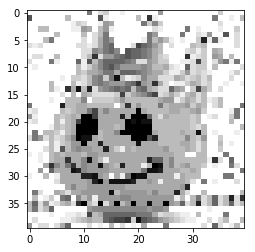

In [20]:
data_out2 = transmit_GHZ_long_data(pic_40_40_GHZ, qubits=[0,1,2], backend=qcomp, monitor=False)
pic_received2 = decode_2darr_GHZ(data_out2, parity)

check_success_rate(pic_40_40, pic_received2)
plot_gray_2d_arr(pic_received2)

#### Run 3

Success = 1251/1600 = 78.1875 %


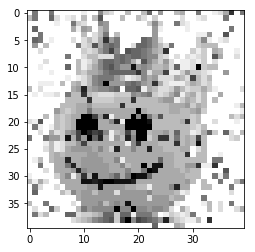

In [21]:
data_out3 = transmit_GHZ_long_data(pic_40_40_GHZ, qubits=[0,1,2], backend=qcomp, monitor=False)
pic_received3 = decode_2darr_GHZ(data_out3, parity)

check_success_rate(pic_40_40, pic_received3)
plot_gray_2d_arr(pic_received3)

#### Run 4

Success = 1170/1600 = 73.125 %


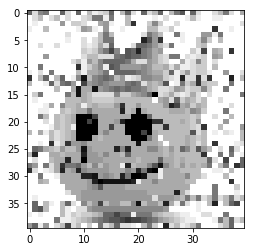

In [22]:
data_out4 = transmit_GHZ_long_data(pic_40_40_GHZ, qubits=[0,1,2], backend=qcomp, monitor=False)
pic_received4 = decode_2darr_GHZ(data_out4, parity)

check_success_rate(pic_40_40, pic_received4)
plot_gray_2d_arr(pic_received4)

#### Run 5

Success = 1112/1600 = 69.5 %


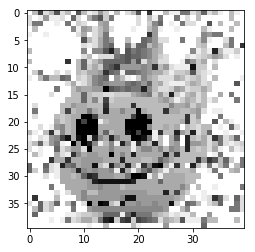

In [23]:
data_out5 = transmit_GHZ_long_data(pic_40_40_GHZ, qubits=[0,1,2], backend=qcomp, monitor=False)
pic_received5 = decode_2darr_GHZ(data_out5, parity)

check_success_rate(pic_40_40, pic_received5)
plot_gray_2d_arr(pic_received5)

##### The average transmission success rate (after 5 runs) = 75.5%

### Step 5: Classical error-correction using majority vote

Using majority vote of 3 runs
Success = 1496/1600 = 93.5 %


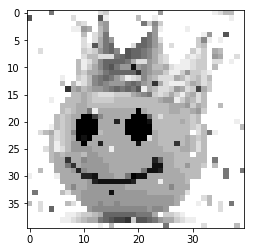

In [76]:
# Majority vote using 3 runs
data1 = data_out1.flatten()
data2 = data_out2.flatten()
data3 = data_out3.flatten()
maj_data_out_GHZ = find_majority_arr([data1,data2,data3], bits=3)

maj_data_out_GHZ = np.array(maj_data_out_GHZ).reshape(40,54)
maj_data_out = decode_2darr_GHZ(maj_data_out_GHZ, parity)
print("Using majority vote of 3 runs")
check_success_rate(pic_40_40, maj_data_out)
plot_gray_2d_arr(maj_data_out)

Using majority vote of 5 runs
Success = 1568/1600 = 98.0 %


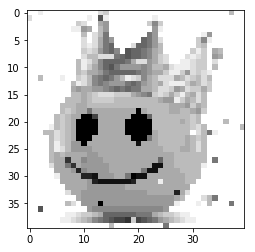

In [78]:
# Majority vote using 5 runs
data4 = data_out4.flatten()
data5 = data_out5.flatten()
maj_data_out_GHZ = find_majority_arr([data1,data2,data3,data4,data5], bits=3)

maj_data_out_GHZ = np.array(maj_data_out_GHZ).reshape(40,54)
maj_data_out = decode_2darr_GHZ(maj_data_out_GHZ, parity)
print("Using majority vote of 5 runs")
check_success_rate(pic_40_40, maj_data_out)
plot_gray_2d_arr(maj_data_out)

# Part 2: Text message transmission

In [67]:
# Import functions related to conversion of text to binary message
try:
    import RS 
except:
    !jupyter nbconvert --to python RS.ipynb
    import RS
    
def check_success_rate_string(string_in, string_out):
    print("Original message:", string_in)
    print("Received message:", string_out)
    correct_count = np.sum(np.multiply([x==y for x,y in zip(list(string_in),list(string_out))],1))
    print("Success rate = %s/%s = %s %%" %(correct_count,len(string_in),correct_count/len(string_in)*100))
    
transmission_type = 1 # 0 for Bell state, 1 for GHZ state
is_picture = 0 # 0 is no, 1 is yes

### Step 1: Convert input text message to arrays of 4 bits
*Text message*: We Love Qiskit Summer Jam 2020.

In [26]:
message = 'We Love Qiskit Summer Jam 2020.' # input message
package, parity = RS.transmitting(message, transmission_type, is_picture) # Encoding the text message into arrays of 4 bits

### Step 2: Check the performance using the simulator first

In [27]:
package_out = transmit_GHZ_long_data(package, qubits=[0,1,2], backend = simulator, monitor=False)

msg_received = RS.receiving(package_out, transmission_type, is_picture, parity) # Decode received package
check_success_rate_string(message, msg_received)

Original message: We Love Qiskit Summer Jam 2020.
Received message: We Love Qiskit Summer Jam 2020.
Success rate = 31/31 = 100.0 %


### Step 3: Check the performance on the quantum hardware: "ibmq_ourense"

#### Run 1

In [28]:
package_out1 = transmit_GHZ_long_data(package, qubits=[0,1,2], backend = qcomp, monitor=True)

msg_received = RS.receiving(package_out1, transmission_type, is_picture, parity) # Decode received package
check_success_rate_string(message, msg_received)

Job Status: job has successfully run
Original message: We Love Qiskit Summer Jam 2020.
Received message: We LoVa Qkskit SuhMer 
am 2020.
Success rate = 25/31 = 80.64516129032258 %


#### Run 2

In [29]:
package_out2 = transmit_GHZ_long_data(package, qubits=[0,1,2], backend = qcomp, monitor=True)

msg_received = RS.receiving(package_out2, transmission_type, is_picture, parity) # Decode received package
check_success_rate_string(message, msg_received)

Job Status: job has successfully run
Original message: We Love Qiskit Summer Jam 2020.
Received message: Ue L/ve Qiskid Aeeeer Jal@220.
Success rate = 21/31 = 67.74193548387096 %


#### Run 3

In [30]:
package_out3 = transmit_GHZ_long_data(package, qubits=[0,1,2], backend = qcomp, monitor=True)

msg_received = RS.receiving(package_out3, transmission_type, is_picture, parity) # Decode received package
check_success_rate_string(message, msg_received)

Job Status: job has successfully run
Original message: We Love Qiskit Summer Jam 2020.
7P`Xe 2qr0.sage: Rm&m)V- u)sOmu$Zw}
Success rate = 6/31 = 19.35483870967742 %


#### Run 4

In [31]:
package_out4 = transmit_GHZ_long_data(package, qubits=[0,1,2], backend = qcomp, monitor=True)

msg_received = RS.receiving(package_out4, transmission_type, is_picture, parity) # Decode received package
check_success_rate_string(message, msg_received)

Job Status: job has successfully run
Original message: We Love Qiskit Summer Jam 2020.
Received message: We Lo6e iskit(SuMmer Jam 2020
Success rate = 26/31 = 83.87096774193549 %


#### Run 5

In [32]:
package_out5 = transmit_GHZ_long_data(package, qubits=[0,1,2], backend = qcomp, monitor=True)

msg_received = RS.receiving(package_out5, transmission_type, is_picture, parity) # Decode received package
check_success_rate_string(message, msg_received)

Job Status: job has successfully run
Original message: We Love Qiskit Summer Jam 2020.
Received message: We Love RiqkiT #umemr Jam 2020.
Success rate = 25/31 = 80.64516129032258 %


##### The average transmission success rate (after 5 runs) = 67.1%

### Step 5: Classical error-correction using majority vote

In [33]:
# Majority vote using 3 runs
maj_data_out = find_majority_arr([package_out1,package_out2,package_out3], bits=4)

msg_received = RS.receiving(maj_data_out, transmission_type, is_picture, parity) # Decode received package
print("Using majority vote of 3 runs")
check_success_rate_string(message, msg_received)

Using majority vote of 3 runs
Original message: We Love Qiskit Summer Jam 2020.
Received message: We L/Ve Qiskit SumMer Jam 2020.
Success rate = 28/31 = 90.32258064516128 %


In [34]:
# Majority vote using 5 runs
maj_data_out = find_majority_arr([package_out1,package_out2,package_out3,package_out4,package_out5], bits=4)

msg_received = RS.receiving(maj_data_out, transmission_type, is_picture, parity) # Decode received package
print("Using majority vote of 5 runs")
check_success_rate_string(message, msg_received)

Using majority vote of 5 runs
Original message: We Love Qiskit Summer Jam 2020.
Received message: We Love Qiskit Summer Jam 2020.
Success rate = 31/31 = 100.0 %
